Some imports:

In [58]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import zCurve as z
import hilbert as h
import math
import numpy as np

We create some "pedestrians crossing a grid made of six neighouring cells" synthetic data:

In [59]:
df = pd.DataFrame()

numstepsincell = 25
gapbetweencells = numstepsincell//2+3

df["sampleTimeStamp.seconds"] = [t // 1000000 for t in range(0, 4000*(numstepsincell+gapbetweencells*5), 4000)]
df["sampleTimeStamp.microseconds"] = [t % 1000000 for t in range(0, 4000*(numstepsincell+gapbetweencells*5), 4000)]

for c in range(6):
    start = [0] * c * gapbetweencells
    inbetween = [math.sin(i/numstepsincell*math.pi)**2 for i in range(numstepsincell)] #a simple way to fake the presence of someone in one of the cells
    end = [0] * (5-c) * gapbetweencells
    
    df["cell_"+str(c)] = start + inbetween + end

df.to_csv('results/pedestrian_crossing/pedestrian_crossing_synthetic.csv', index=False, sep=";")

We plot the data to explore the crossing:

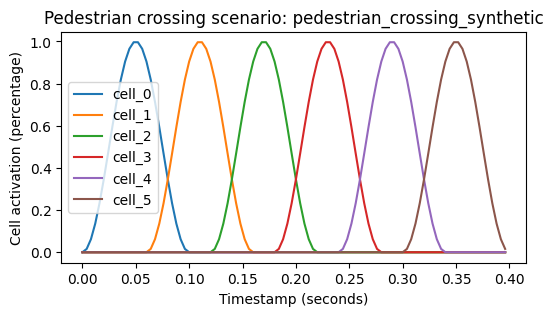

In [60]:
file_path = "results/pedestrian_crossing/pedestrian_crossing_synthetic.csv"
file_basename = os.path.splitext(os.path.basename(file_path))[0] # Get the file basename without extension

data = pd.read_csv(file_path, sep=';')
data['timestamp'] = data['sampleTimeStamp.seconds'] * 1_000_000 + data['sampleTimeStamp.microseconds']

common_figsize = (6, 3)  # Common figure size for all plots
plt.figure(figsize=common_figsize)
for i in range(6):
    plt.plot(data['timestamp']/1000000, data['cell_'+str(i)], label='cell_'+str(i))

plt.xlabel("Timestamp (seconds)")
plt.ylabel("Cell activation (percentage)")
plt.title(f"Pedestrian crossing scenario: {file_basename}")
plt.legend()
plt.savefig("results/pedestrian_crossing/"+file_basename+"_signals", bbox_inches="tight")
plt.show()
plt.close()

Build Morton (Z-order) Index:

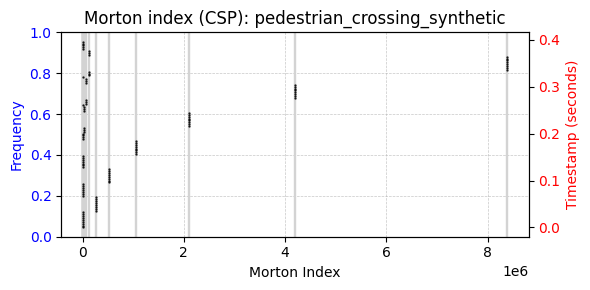

In [61]:
scale = 10
columns = [scale*data['cell_'+str(i)] for i in range(6)]
data['Morton_Index'] = [z.interlace(*[int(float(c0)), int(float(c1)), int(float(c2)), int(float(c3)), int(float(c4)), int(float(c5))], bits_per_dim=10) for c0, c1, c2, c3, c4, c5 in zip(*columns)]

fig, ax1 = plt.subplots(figsize=common_figsize)
ax1.eventplot(data['Morton_Index'],
              orientation='horizontal',
              colors=["lightgray"],
              alpha=0.5,
              lineoffsets=0.5)
ax1.set_xlabel("Morton Index")
ax1.set_ylabel('Frequency', color='b')
ax1.set_ylim((0, 1))
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.scatter(data['Morton_Index'],
            data['timestamp']/1000000.0,
            color='black',
            s=0.5,
            alpha=0.8,
            label="Timestamps")
ax2.set_ylabel("Timestamp (seconds)", color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title(f"Morton index (CSP): {file_basename}")
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("results/pedestrian_crossing/"+file_basename+"_csp_m", bbox_inches="tight")
plt.show()
plt.close()

Same, but for Hilbert:

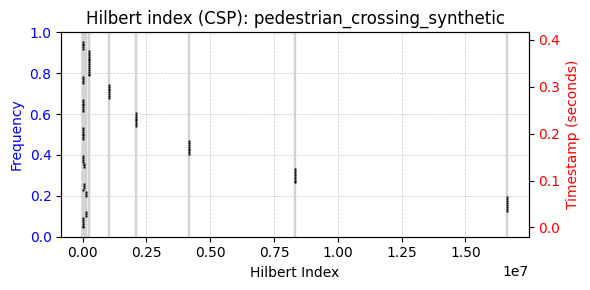

In [62]:
data["Hilbert_Index"] = h.encode(np.ascontiguousarray(np.array(columns).T), 6, 10)

fig, ax1 = plt.subplots(figsize=common_figsize)
ax1.eventplot(data['Hilbert_Index'],
              orientation='horizontal',
              colors=["lightgray"],
              alpha=0.5,
              lineoffsets=0.5)
ax1.set_xlabel("Hilbert Index")
ax1.set_ylabel('Frequency', color='b')
ax1.set_ylim((0, 1))
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.scatter(data['Hilbert_Index'],
            data['timestamp']/1000000.0,
            color='black',
            s=0.5,
            alpha=0.8,
            label="Timestamps")
ax2.set_ylabel("Timestamp (seconds)", color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title(f"Hilbert index (CSP): {file_basename}")
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("results/pedestrian_crossing/"+file_basename+"_csp_h", bbox_inches="tight")
plt.show()
plt.close()